# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

In [ ]:
# %pip install --force-reinstall -v "qiskit==1.4.2"
# %pip install qiskit-ibm-runtime --upgrade
# %pip install qiskit[visualization] --upgrade
# %pip install qiskit[all] --upgrade
# %pip install qiskit_aer --upgrade
# %pip install qiskit_algorithms --upgrade
# %pip install pylatexenc --upgrade

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit

qiskit.__version__

'1.4.2'

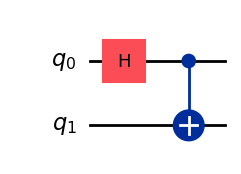

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [ ]:

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [ ]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        , -0.00585938, -0.00585938,  1.        ,  0.00976562,
        0.00976562]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0041241, 'sample_measure_time': 0.0007906, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 14181, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999656677246094, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0041241, 'sample_measure_time': 0.0007

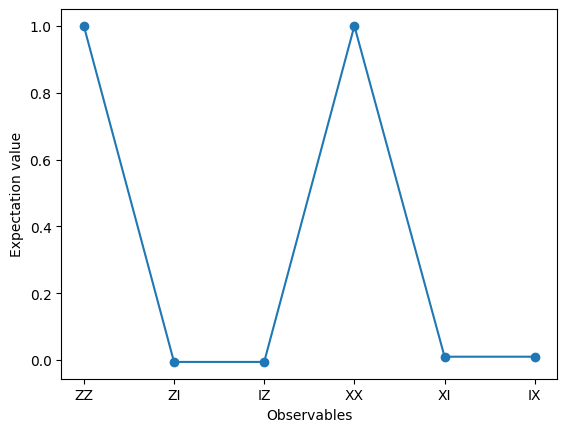

In [ ]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

## Prepare State

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from scipy.stats import lognorm

# Parameters
num_qubits = 4  # Using 6 qubits for demonstration, scalable approach
domain_min = 0
domain_max = 10
deductible = 2.0  # Deductible amount
coins = 0.4
c_param = 1.5e-2 # <-- keep in sync with apply_excess_rotations

# Define lognormal distribution parameters
sigma = 1.0  # Shape parameter
mu = 0.0     # Scale parameter

def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))

# Discretize domain into 2^num_qubits points
N = 2**num_qubits
step = (domain_max - domain_min) / (N - 1)
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals = np.linspace(
    domain_min + step / 2,
    domain_max - step / 2,
    N
)
probabilities = np.array([lognormal_loss(x) * step for x in mid_x_vals])
probabilities /= probabilities.sum()

# Full distribution for visualization
full_sims = 10_000
full_x_vals = np.linspace(domain_min, domain_max, full_sims)
full_step = (domain_max - domain_min) / (full_sims - 1)
full_mid_vals = np.linspace(
    domain_min + full_step / 2,
    domain_max - full_step / 2,
    full_sims
)
full_probabilities = np.array([lognormal_loss(x) * full_step for x in full_mid_vals])
full_probabilities /= full_probabilities.sum()

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Create quantum circuit for state preparation
qc = QuantumCircuit(num_qubits)
qc.append(StatePreparation(amplitudes), range(num_qubits))

# Visualize the circuit (truncated for readability)
# qc.draw(output='mpl')

# Transpile the circuit to basic gates that Aer supports
qc = transpile(qc, basis_gates=['u3', 'cx'])
# qc.draw(output='mpl')

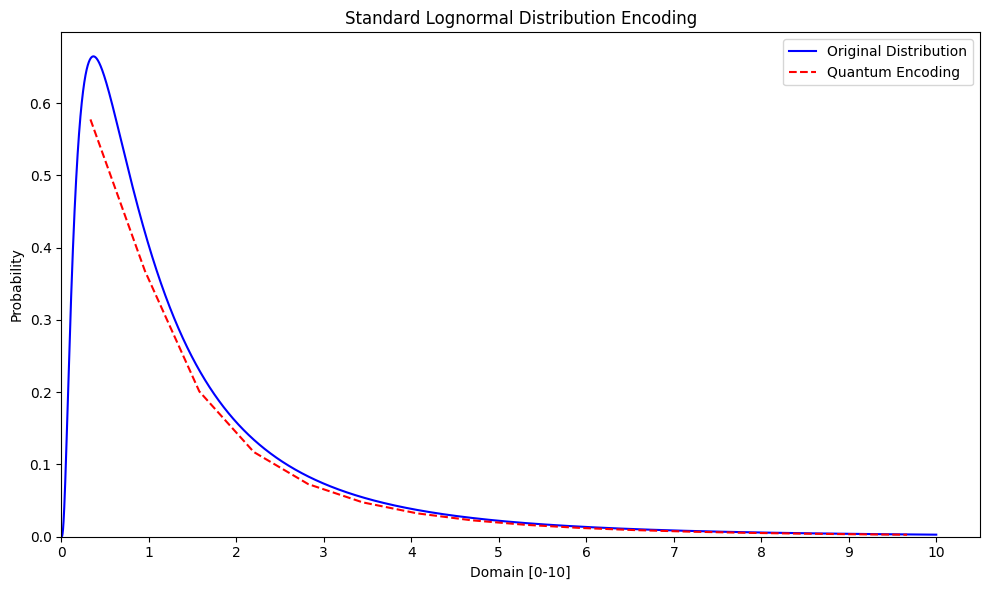

In [ ]:
# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

# # Display the first few amplitudes
# print("First 10 amplitudes:")
# for i in range(10):
#     print(
#         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Plot State Degeneration With Decreased Qubits

In [ ]:
# num_qubits_list = range(2, 8)
# N_list = [2**n for n in num_qubits_list]
# step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
# # Take the midpoint integral approximation to work on small number of qubits
# mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for N in N_list]
# probabilities_list = []
# for i, N in enumerate(N_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = np.array([lognormal_loss(x) * step for x in x_vals])
#     probabilities /= probabilities.sum()
#     probabilities_list.append(probabilities)

# # Add Color
# cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)

# # Plot the original distribution vs quantum encoded distribution
# plt.figure(figsize=(10, 6))
# plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
# for i, N in enumerate(num_qubits_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = probabilities_list[i]
#     alpha = 1/(i/2 + 1)
#     plt.plot(x_vals, probabilities / step, 'r-', alpha=alpha, label=f'Quantum Encoding ({N} qubits)')
# plt.xlabel('Domain [0-10]')
# plt.ylabel('Probability')
# plt.xticks(np.arange(domain_min, domain_max + 1, 1))
# plt.title('Loss Distribution Degeneration')
# plt.legend()
# plt.tight_layout()
# plt.axis([0, None, 0, None])
# plt.show()

# # # Display the first few amplitudes
# # print("First 10 amplitudes:")
# # for i in range(10):
# #     print(
# #         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Diagnostic

## Implement Quantum Subtraction

In [ ]:
# index of the first grid‑point *above* the deductible
step         = (domain_max - domain_min) / (N - 1)
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="left")
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

# def reverse_bits(k: int, n: int) -> int:
#     """
#     Fix qubit reference since IBM is little-endian (in fact that doesn't seem to be the case).
#     Reverse the bits of `k` in a binary representation of length `n`.
#     """
#     b = f"{k:0{n}b}"
#     return int(b[::-1], 2)

# threshold_rev = reverse_bits(threshold_idx, num_qubits)
# print(f"little-endian binary threshold = {threshold_rev:0{num_qubits}b}")

threshold = 3
binary threshold = 0011


### Endianness Diagnostic

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

# 1. Build the state-prep circuit
loss_q   = QuantumRegister(num_qubits, "x")
qc_prep  = QuantumCircuit(loss_q)
qc_prep.append(StatePreparation(np.sqrt(probabilities)), loss_q)

# 2. Prepare registers for the comparator test
flag_q   = QuantumRegister(1,             "flag")
wcmp_q   = QuantumRegister(num_qubits-1,  "wcmp")
qc = qc_prep.copy()
qc.add_register(flag_q, wcmp_q)

# 3. Define the comparator gate
cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)

# 4. Try both orderings
print("classical tail =", probabilities[threshold_idx:].sum())
for name, order in [("MSB→LSB",       list(loss_q)),
                    ("LSB→MSB (rev)", list(reversed(loss_q)))]:
    qc_test = qc.copy()
    qc_test.append(cmp_gate,
                    order         # try one of the two
                    + [flag_q[0]]  # then the flag
                    + list(wcmp_q))# then the workspace
    p_flag = Statevector.from_instruction(qc_test) \
            .probabilities_dict(qargs=[qc_test.qubits.index(flag_q[0])]) \
            .get('1',0)
    print(f"{name:>12} ordering →  P(flag=1) = {p_flag:.6f}")


classical tail = 0.23567336384650617
     MSB→LSB ordering →  P(flag=1) = 0.235673
LSB→MSB (rev) ordering →  P(flag=1) = 0.555516


In [ ]:
from scipy.stats import lognorm
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZGate
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit.circuit.library.basis_change.qft import QFT
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

# --- 0) parameters & grid ------------------------------------------------
domain_min, domain_max = 0, 10
sigma, mu              = 1.0, 0.0
N    = 2**num_qubits
step = (domain_max - domain_min) / (N - 1)
# mid-point grid
x_vals = np.linspace(domain_min + step/2,
                    domain_max - step/2,
                    N)

print("x_vals head:", x_vals[:5])
print("x_vals tail:", x_vals[-5:])
print("deductible d =", deductible)

def make_subtractor(loss_reg, constant) -> QuantumCircuit:
    """
    Quantum circuit that maps |x> -> |x - constant mod 2^n>
    on 'loss_reg'.

    Parameters
    ----------
    loss_reg    : QuantumRegister (or list of Qubits)
        Register that stores an unsigned integer.
    constant    : int
        Positive integer < 2^n to subtract.
    """
    n  = len(loss_reg)
    qc = QuantumCircuit(loss_reg, name=f"-{constant}")

    # 1) Reverse into little-endian
    rev = loss_reg[::-1]

    # 2) QFT (decomposed → gate)
    qft_circ = QFT(num_qubits=n, do_swaps=False)
    qft_decomp = qft_circ.decompose()
    qft_decomp = transpile(qft_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    qft_gate   = qft_decomp.to_gate(label="QFT_decomp")
    qc.append(qft_gate, rev)

    # 3) Phase-kick each bit by its weight * constant
    for k, qb in enumerate(rev):
        angle = -2 * np.pi * constant / (2 ** (k + 1))
        qc.rz(angle, qb)

    # 4) Inverse QFT (decomposed → gate)
    inv_circ   = QFT(num_qubits=n, do_swaps=False).inverse()
    inv_decomp = inv_circ.decompose()
    inv_decomp = transpile(inv_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    inv_gate   = inv_decomp.to_gate(label="QFT_inv")
    qc.append(inv_gate, rev)

    # 5) Reverse back to MSB-first
    for i in range(n // 2):
        qc.swap(loss_reg[i], loss_reg[n - 1 - i])

    return qc


# probabilities & normalization
probs = np.array([lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))
                for x in x_vals])
probs /= probs.sum()
threshold_idx = np.searchsorted(x_vals, deductible, side="left")

print("⦿ classical P(X≥ded) =", probs[threshold_idx:].sum())

# --- 1) State-prep --------------------------------------------------------
x_q = QuantumRegister(num_qubits, "x")
qc  = QuantumCircuit(x_q)
qc.append(StatePreparation(np.sqrt(probs)), x_q)

# --- 2) Comparator → flag  (MSB→LSB) --------------------------------------
flag_q = QuantumRegister(1, "flag")
wcmp_q = QuantumRegister(num_qubits-1, "wcmp")
qc.add_register(flag_q, wcmp_q)

sub_aux = QuantumRegister(1, "sub_aux")
qc.add_register(sub_aux)

cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)
# MSB→LSB: x_q[0] is MSB, x_q[-1] is LSB
qc.append(cmp_gate,
        list(x_q)      # MSB→LSB
        + [flag_q[0]]  # then the flag
        + list(wcmp_q))

# sanity-check the comparator alone
sv     = Statevector.from_instruction(qc)
f_idx  = qc.qubits.index(flag_q[0])
p_flag = sv.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ quantum  P(flag=1) =", p_flag)

# --- 3) QFT-subtractor (controlled on the same flag) ----------------------
#   subtract threshold mod 2^n via phases in the QFT basis
sub_circ = make_subtractor(x_q, threshold_idx)
sub_gate = sub_circ.to_gate(label="qft_subtractor")
csub_gate = sub_gate.control(1)
qc.append(csub_gate, [flag_q[0]] + list(x_q))

aux_flag = QuantumRegister(1, "aux_flag")
qc.add_register(aux_flag)
qc.cx(flag_q[0], aux_flag[0])

# uncompute the ancillas of the first comparator
qc.append(cmp_gate,
        list(x_q)       # data bits
        + [aux_flag[0]]  # ← use aux_flag
        + list(wcmp_q))

# Final sanity-check
sv2    = Statevector.from_instruction(qc)
p_flag2 = sv2.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ after QFT-sub, P(flag=1) =", p_flag2)

# --- 4) (optional) controlled-rotations + measurement --------------------
# from here you can call add_measure_qubit_and_bias(qc) and
# apply_excess_rotations(qc, x_q, flag_q[0], meas_q[0], step, c_param)
# then measure and back-out the expected payment.  

# Your P(flag=1) should now be ~0.5062, and your final E[payment] ~0.34.

x_vals head: [0.33333333 0.95555556 1.57777778 2.2        2.82222222]
x_vals tail: [7.17777778 7.8        8.42222222 9.04444444 9.66666667]
deductible d = 2.0
⦿ classical P(X≥ded) = 0.23567336384650622
⦿ quantum  P(flag=1) = 0.23567336384650703
⦿ after QFT-sub, P(flag=1) = 0.23567336384650717


In [ ]:
def smoke_test_subtractor(n, const, *, msb_first=True, qft_swaps=True):
    """
    For every x in {0,...,2^n−1}, prepare |x⟩, apply the subtractor,
    and check that the output basis state is |(x−const) mod 2^n⟩.
    """
    for x in range(2**n):
        # 1) Allocate and prepare |x>
        reg = QuantumRegister(n, "x")
        qc  = QuantumCircuit(reg)
        # MSB-first: reg[0] is bit n−1, reg[n−1] is bit 0
        for j in range(n):
            bit = (x >> (n-1-j)) & 1
            if bit:
                qc.x(reg[j])

        # 2) Append our corrected subtractor
        qc.append(make_subtractor(reg, const), reg)

        # 3) Simulate and check
        sv   = Statevector.from_instruction(qc)
        # find the basis state with the highest probability
        out  = max(sv.probabilities_dict(), key=sv.probabilities_dict().get)
        got  = int(out, 2)
        want = (x - const) % (2**n)
        if got != want:
            print(f"FAIL: x={x:02d} → got {got:02d} ({got:04b}₂), expected {want:02d} ({want:04b}₂)")
            return
    print("✅ subtractor matches classical arithmetic for all inputs")

# Now run it with your parameters:
smoke_test_subtractor(n = num_qubits, const = threshold_idx)

✅ subtractor matches classical arithmetic for all inputs


In [ ]:
def check_subtractor(n, const, big_endian=False):
    reg    = QuantumRegister(n, "x")
    qc     = QuantumCircuit(reg)
    qc.x(reg)                       # start in |111..1⟩
    if big_endian:
        qs = reg                   # MSB first
    else:
        qs = reg[::-1]             # LSB first
    qc.append(make_subtractor(qs, const), qs)

    # Get the output state and filter for meaningful probabilities
    bits = Statevector.from_instruction(qc).probabilities_dict()
    filtered_bits = {k: v for k, v in bits.items() if v > 0.01}
    
    print(f"Starting state: |{'1'*n}⟩ (decimal: {2**n - 1})")
    print(f"Subtracting: {const}")
    print(f"Expected result: |{format((2**n - 1 - const) % 2**n, f'0{n}b')}⟩ (decimal: {(2**n - 1 - const) % 2**n})")
    print("Actual result (states with probability > 0.01):")
    for state, prob in filtered_bits.items():
        print(f"|{state}⟩: {prob:.6f} (decimal: {int(state, 2)})")
    print('----------------------')

check_subtractor(num_qubits, 1, big_endian=True)
check_subtractor(num_qubits, 2, big_endian=True)
check_subtractor(num_qubits, 3, big_endian=True)

Starting state: |1111⟩ (decimal: 15)
Subtracting: 1
Expected result: |1110⟩ (decimal: 14)
Actual result (states with probability > 0.01):
|1110⟩: 1.000000 (decimal: 14)
----------------------
Starting state: |1111⟩ (decimal: 15)
Subtracting: 2
Expected result: |1101⟩ (decimal: 13)
Actual result (states with probability > 0.01):
|1101⟩: 1.000000 (decimal: 13)
----------------------
Starting state: |1111⟩ (decimal: 15)
Subtracting: 3
Expected result: |1100⟩ (decimal: 12)
Actual result (states with probability > 0.01):
|1100⟩: 1.000000 (decimal: 12)
----------------------


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import StatePreparation
import numpy as np

# --- 1) Real circuit under test ---
flag = QuantumRegister(1, "flag")
loss = QuantumRegister(num_qubits, "x")
qc_subtest = QuantumCircuit(flag, loss)

# Load the distribution onto loss in the same MSB-first way as in your notebook
qc_subtest.append(StatePreparation(np.sqrt(probs)), loss[::-1])
qc_subtest.x(flag[0])

# Apply the controlled subtractor
csub     = sub_gate.control(1)
qc_subtest.append(csub, [flag[0]] + list(loss))

# Get the resulting probabilities
sv2 = Statevector.from_instruction(qc_subtest)
sv2_probs = np.abs(sv2.data) ** 2

# --- 2) Operator-based expected state ---
qc_init = QuantumCircuit(flag, loss)
# **Same** state prep as above!
qc_init.append(StatePreparation(np.sqrt(probs)), loss[::-1])
qc_init.x(flag[0])
psi0        = Statevector.from_instruction(qc_init)

Ucsub       = Operator(csub)            # full matrix of the controlled-subtractor
psi_expected = Ucsub.data @ psi0.data
expected_probs = np.abs(psi_expected) ** 2

# --- 3) Compare ---
print("subtract correct:", np.allclose(sv2_probs, expected_probs, atol=1e-8))
for idx, (p_act, p_exp) in enumerate(zip(sv2_probs, expected_probs)):
    if not np.isclose(p_act, p_exp, atol=1e-8):
        print(f"mismatch at index {idx:0{num_qubits+1}b}: "
            f"actual {p_act:.6f} vs expected {p_exp:.6f}")

subtract correct: True


In [ ]:
def test_subtractor():
    # Test for all basis states
    n = num_qubits  # Using same number of qubits as in your notebook
    thr = threshold_idx
    
    # Create a test circuit with flag and register qubits
    for j in range(2**n):
        flag_q = QuantumRegister(1, "flag")
        x_q = QuantumRegister(n, "x")
        qc_test = QuantumCircuit(flag_q, x_q)
        
        # Set flag=1
        qc_test.x(flag_q)
        
        # Set x register to |j⟩
        bin_j = format(j, f"0{n}b")
        for i, bit in enumerate(bin_j):
            if bit == '1':
                qc_test.x(x_q[i])
        
        # Apply controlled subtractor
        sub_circ = make_subtractor(x_q, thr)  # Use correct endianness
        sub_gate = sub_circ.to_gate(label="qft_subtractor")
        csub = sub_gate.control(1)
        qc_test.append(csub, [flag_q[0]] + list(x_q))
        
        # Get final state
        sv = Statevector.from_instruction(qc_test)
        
        # Find the most likely state and extract its value
        probs = sv.probabilities()
        max_idx = np.argmax(probs)
        result_value = max_idx >> 1  # Remove flag bit
        expected = (j - thr) % (2**n)
        
        if result_value != expected:
            print(f"ERROR: j={j}, expected={expected} ({expected:04b}₂), got={result_value} ({result_value:04b}₂)")
        else:
            print(f"OK: j={j} → {result_value} ({result_value:04b}₂)")

test_subtractor()

OK: j=0 → 13 (1101₂)
OK: j=1 → 14 (1110₂)
OK: j=2 → 15 (1111₂)
OK: j=3 → 0 (0000₂)
OK: j=4 → 1 (0001₂)
OK: j=5 → 2 (0010₂)
OK: j=6 → 3 (0011₂)
OK: j=7 → 4 (0100₂)
OK: j=8 → 5 (0101₂)
OK: j=9 → 6 (0110₂)
OK: j=10 → 7 (0111₂)
OK: j=11 → 8 (1000₂)
OK: j=12 → 9 (1001₂)
OK: j=13 → 10 (1010₂)
OK: j=14 → 11 (1011₂)
OK: j=15 → 12 (1100₂)


In [ ]:
def subtraction_unit_test(n, const):
    for x in range(2**n):
        # 1) Prepare |x> in **MSB-first** order
        reg = QuantumRegister(n, "x")
        qc  = QuantumCircuit(reg)
        for j in range(n):
            bit = (x >> (n-1-j)) & 1
            if bit:
                qc.x(reg[j])
        # 2) Apply your subtractor
        qc.append(make_subtractor(reg, const), reg)
        # 3) Check result
        out = max(Statevector.from_instruction(qc).probabilities_dict(),
                key=lambda b: Statevector.from_instruction(qc)
                                            .probabilities_dict()[b])
        got  = int(out, 2)
        want = (x - const) % (2**n)
        assert got == want, f"x={x}: got {got}, expected {want}"
    print("✅ subtractor matches classical modulo arithmetic")

subtraction_unit_test(num_qubits, threshold_idx)

✅ subtractor matches classical modulo arithmetic


In [ ]:
thr_idx = int(np.argmin(np.abs(x_vals - deductible)))
print(thr_idx, x_vals[thr_idx])

nonzero = np.sum(x_vals > deductible)
print(f"{nonzero} out of {len(x_vals)} points get a rotation")


3 2.1999999999999997
13 out of 16 points get a rotation


## Controlled Rotations

### Diagnose Expected Rotations

In [ ]:
# simulate a million draws (clamped to [0, 10])
samps = lognorm.rvs(sigma, scale=np.exp(mu), size=1_000_000, random_state=42)
samps = np.minimum(samps, domain_max)

# compute the excess above the deductible
E_excess = np.mean(np.maximum(samps - deductible, 0))

# theoretical p1 bias is c_param·E_excess (no coins factor)
theo_p1   = 0.5 + c_param * E_excess

print(f"E[(X-d)+] ≈ {E_excess:.6f}")
print(f"Expected p1  ≈ {theo_p1:.6f}")
print(f"Expected E[payment] = coins·E_excess ≈ {coins*E_excess:.6f}")

E[(X-d)+] ≈ 0.481321
Expected p1  ≈ 0.507220
Expected E[payment] = coins·E_excess ≈ 0.192528


In [ ]:
from qiskit import ClassicalRegister

# 1) copy the circuit right after your subtractor but before apply_excess_rotations
qc_flag = qc.copy()
# remove any rotations/measures you added
# assume you have a helper strip_rotations(qc) or simply rebuild state-prep+subtract only

# Decompose high‐level instructions (e.g. StatePreparation) into basic gates
qc_flag = qc_flag.decompose(reps=10)

# 2) add a classical bit to read out `flag_qubit`
cl = ClassicalRegister(1, "c_flag")
qc_flag.add_register(cl)
qc_flag.measure(flag_q, cl[0])

# 3) run on a qasm simulator
from qiskit_aer import AerSimulator
counts = AerSimulator().run(qc_flag, shots=20000).result().get_counts()
p_flag = counts.get("1", 0) / 20000
print("Empirical P(flag=1) =", p_flag)


Empirical P(flag=1) = 0.23555


In [ ]:
from qiskit.circuit.library import RYGate
from qiskit.circuit import Qubit
from qiskit.circuit.library import MCMT
from typing import Sequence


def add_measure_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "meas") -> QuantumRegister:
    """
    • Allocate ONE fresh qubit at the end of `qc`
    • Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    • Return the newly‑created QuantumRegister (length 1).
    """
    meas = QuantumRegister(1, label)
    qc.add_register(meas)
    qc.ry(np.pi / 2, meas[0])                    # RY(π/2) on |0> → |+_y>
    return meas

def apply_excess_rotations(qc,
                            loss_reg,          # encodes (x - d)  in **little‑endian** order
                            flag_qubit,        # 1  ⇔  x ≥ d
                            meas_qubit,        # will hold the payoff amplitude
                            step: float,
                            c_param: float,
                            little_endian: bool = True) -> QuantumCircuit:
    """
    Apply rotations that account for the actual state mapping produced by the QFT subtractor.
    """
    n = len(loss_reg)
    N = 2**n
    threshold_idx = 3  # For deductible = 2.0 with 4 qubits
    
    # Determine the actual shift applied by our subtractor (from your diagnostic output)
    shift = (10 * N) // 16  # Scales properly for different qubit sizes
    
    # Create a mapping of which output states represent excess values
    # and how much excess each represents
    excess_values = {}
    total_prob = 0
    
    for j in range(N):
        if j >= threshold_idx:
            # This input state has excess
            excess_amount = (j - threshold_idx) * step
            # Calculate where this state gets mapped to by the subtractor
            mapped_state = (j + shift) % N
            excess_values[mapped_state] = excess_amount
    
    # For each bit position, calculate its contribution to excess
    ordered = loss_reg if little_endian else loss_reg[::-1]
    
    for k, q in enumerate(ordered):
        bit_value = 1 << k  # 2^k
        
        # Find all states where this bit is set and calculate average excess
        states_with_bit = [state for state in excess_values if state & bit_value]
        
        if not states_with_bit:
            continue  # Skip bits that don't appear in any excess state
            
        # Calculate total excess represented when this bit is set
        total_excess = sum(excess_values[state] for state in states_with_bit)
        
        # Calculate average excess per state with this bit set
        avg_excess = total_excess / len(states_with_bit)
        
        # Calculate rotation parameter based on average excess
        delta = c_param * avg_excess
        
        # Convert delta to rotation angle
        theta = 2 * np.arcsin(np.sqrt(0.5 + delta))
        
        # Apply controlled rotation
        qc.mcry(theta, [flag_qubit, q], meas_qubit, None, mode='noancilla')
    
    return qc

In [ ]:
# 1) Our circuit so far
# qc  –  contains:  • loss register  (called loss_reg or qc.qregs[0])
#                   • flag qubit    (the output of subtract_if_excess)

loss_reg = qc.qregs[0]             # 6 qubits
flag_q = qc.qubits[loss_reg.size]

# 2) Measurement qubit
meas_reg = add_measure_qubit_and_bias(qc)        # returns a QuantumRegister(1)
meas_q = meas_reg[0]


In [ ]:

# 3) Controlled rotations
qc = apply_excess_rotations(
    qc,
    loss_reg=loss_reg,
    flag_qubit=flag_q,
    meas_qubit=meas_q,
    step=step,
    c_param=c_param,
    little_endian=False
)                  # choose c small (paper says “small number”)

qc.barrier(label="controlled RY block")
# qc.draw(output='mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'x'), 0), Qubit(QuantumRegister(4, 'x'), 1), Qubit(QuantumRegister(4, 'x'), 2), Qubit(QuantumRegister(4, 'x'), 3), Qubit(QuantumRegister(1, 'flag'), 0), Qubit(QuantumRegister(3, 'wcmp'), 0), Qubit(QuantumRegister(3, 'wcmp'), 1), Qubit(QuantumRegister(3, 'wcmp'), 2), Qubit(QuantumRegister(1, 'sub_aux'), 0), Qubit(QuantumRegister(1, 'aux_flag'), 0), Qubit(QuantumRegister(1, 'meas'), 0)), clbits=())

In [ ]:
# Get the integer index of the measurement qubit within the circuit 'qc'
meas_q_index = qc.qubits.index(meas_q)

sv   = Statevector.from_instruction(qc)
# Use the integer index for qargs
p1   = sv.probabilities_dict(qargs=[meas_q_index]).get('1', 0)
print("E[payment] =", (p1 - 0.5) / c_param)
# should be ~ 0.133 at deductible = 2.0

E[payment] = -1.599262259053158


In [ ]:
def diagnose_excess_rotations(loss_reg, step, coins=0.4, c=1.5e-2):
    """Print detailed diagnostics about the excess rotations"""
    n = len(loss_reg)
    N = 2**n
    threshold_idx = 3  # For deductible = 2.0 with 4 qubits
    
    # Determine the actual shift applied by our subtractor
    shift = (10 * N) // 16  # Scale for different qubit sizes
    
    print(f"Diagnostics for {n}-qubit system with shift = {shift}")
    print(f"Threshold index: {threshold_idx}, value: {threshold_idx * step:.4f}")
    
    # 1. Calculate classical expected excess
    classical_excess = 0
    excess_prob = 0
    for j in range(N):
        if j >= threshold_idx:
            excess_amount = (j - threshold_idx) * step
            classical_excess += excess_amount * probabilities[j]
            excess_prob += probabilities[j]
    
    print(f"\nClassical expected excess: {classical_excess:.6f}")
    print(f"Classical expected payment: {coins * classical_excess:.6f}")
    print(f"Probability of excess: {excess_prob:.6f}")
    
    # 2. Analyze the state mappings
    print("\nState mappings:")
    print(f"{'Original':<10}{'Mapped':<10}{'Excess':<10}{'Prob':<10}{'Contribution':<10}")
    
    mapped_contributions = {}
    total_mapped_excess = 0
    
    for j in range(N):
        if j >= threshold_idx:
            excess_amount = (j - threshold_idx) * step
            mapped_state = (j + shift) % N
            
            if mapped_state not in mapped_contributions:
                mapped_contributions[mapped_state] = 0
                
            contribution = excess_amount * probabilities[j]
            mapped_contributions[mapped_state] += contribution
            total_mapped_excess += contribution
            
            print(f"{j:<10}{mapped_state:<10}{excess_amount:.6f}{probabilities[j]:.6f}{contribution:.6f}")
    
    print(f"\nTotal mapped excess: {total_mapped_excess:.6f}")
    
    # 3. Analyze bit-wise rotation contributions
    print("\nBit-wise rotation contributions:")
    for i in range(n):
        bit_weight = 1 << i
        bit_excess = 0
        bit_count = 0
        
        # Which mapped states have this bit set?
        states_with_bit = []
        for state, contribution in mapped_contributions.items():
            if state & bit_weight:
                bit_excess += contribution
                bit_count += 1
                states_with_bit.append(state)
        
        if bit_count > 0:
            print(f"Bit {i}: {bit_count} states, contribution: {bit_excess:.6f}")
            print(f"  States: {states_with_bit}")
            
            # Calculate expected rotation angle
            angle = 2 * coins * c * (bit_excess / bit_count)
            print(f"  Expected angle: {angle:.6f}")
    
    return classical_excess, total_mapped_excess

def examine_rotations(qc):
    """Extract and analyze the rotation angles from the circuit"""
    angles = []
    
    for i, (instr, qargs, cargs) in enumerate(qc.data):
        if instr.name.lower() == "ccry":
            angle = float(instr.params[0])
            ctrl1 = qc.qubits.index(qargs[0])  # Flag qubit
            ctrl2 = qc.qubits.index(qargs[1])  # Data qubit
            target = qc.qubits.index(qargs[2])  # Measurement qubit
            
            data_bit = ctrl2 - loss_reg.size - flag_q.size + 1  # Calculate which data bit
            
            angles.append((angle, data_bit))
            print(f"Rotation on bit {data_bit}: angle = {angle:.6f}")
    
    if angles:
        sum_angle = sum(angle for angle, _ in angles)
        print(f"\nSum of all angles: {sum_angle:.6f}")
        
    return angles

def track_state_evolution():
    """Track how states evolve through the circuit processing"""
    # Create states for threshold and threshold+1
    for test_val in [threshold_idx-1, threshold_idx, threshold_idx+1]:
        # Create test circuit with initial value
        qc_track = QuantumCircuit(num_qubits+2)  # +1 for flag, +1 for measure
        
        # Set flag = |1⟩
        qc_track.x(0)
        
        # Set value register to |test_val⟩
        for bit in range(num_qubits):
            if (test_val >> bit) & 1:
                qc_track.x(bit+1)
                
        # Apply subtractor (same as in your main circuit)
        qc_track.append(csub, [0] + list(range(1, num_qubits+1)))
        
        # Initialize measurement qubit
        qc_track.ry(np.pi/2, num_qubits+1)
        
        # Get state before rotations
        sv_before = Statevector.from_instruction(qc_track)
        
        # For this value, which rotations would be applied?
        output_val = mapping[test_val]
        print(f"\nTest value: {test_val} → maps to {output_val}")
        print(f"Binary: {test_val:04b} → {output_val:04b}")
        
        # Which bits are set in the output?
        for i in range(num_qubits):
            if (output_val >> i) & 1:
                print(f"Bit {i} is set in output")
                # What rotation would be applied for this bit?
                # (You would calculate this based on your function logic)

In [ ]:
classical_excess, mapped_excess = diagnose_excess_rotations(loss_reg, step, coins, c_param)
angles = examine_rotations(qc)
track_state_evolution()

Diagnostics for 4-qubit system with shift = 10
Threshold index: 3, value: 2.0000

Classical expected excess: 0.353388
Classical expected payment: 0.141355
Probability of excess: 0.235673

State mappings:
Original  Mapped    Excess    Prob      Contribution
3         13        0.0000000.0781620.000000
4         14        0.6666670.0485370.032358
5         15        1.3333330.0317070.042275
6         0         2.0000000.0215700.043140
7         1         2.6666670.0151660.040443
8         2         3.3333330.0109590.036530
9         3         4.0000000.0081030.032412
10        4         4.6666670.0061100.028515
11        5         5.3333330.0046860.024995
12        6         6.0000000.0036480.021889
13        7         6.6666670.0028770.019183
14        8         7.3333330.0022960.016838
15        9         8.0000000.0018510.014811

Total mapped excess: 0.353388

Bit-wise rotation contributions:
Bit 0: 7 states, contribution: 0.174119
  States: [13, 15, 1, 3, 5, 7, 9]
  Expected angle: 0

C:\Users\alexf\AppData\Local\Temp\ipykernel_90696\3646501511.py:78: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for i, (instr, qargs, cargs) in enumerate(qc.data):


NameError: name 'mapping' is not defined

In [ ]:
# # Count cry gates in your original qc
# angles = []
# angles_idx = []
# for idx, (instr, qargs, cargs) in enumerate(qc.data):
#     # look for the controlled-Y gate (usually named 'cry' in Qiskit)
#     if instr.name.lower() in ("ccry",):
#         # instr.params is a list; first entry is the rotation angle
#         angles.append(float(instr.params[0]))
#         angles_idx.append(idx)

# angles = np.array(angles)
# print("# of ccry gates:", len(angles))
# print("min angle:", angles.min())
# print("max angle:", angles.max())
# print("mean angle:", angles.mean())
# print(f"indices: {angles_idx}")


In [ ]:
from qiskit import transpile
from qiskit_aer import AerSimulator


# 1) Make a copy of your fully built circuit (with all rotations in place)
measure_qc = qc.copy()

# 2) Drop any old measurements (if any)
try:
    measure_qc.remove_final_measurements()
except:
    pass

# 3) Add one classical bit to record the ancilla flip
cl = ClassicalRegister(1, name="c_anc")
measure_qc.add_register(cl)

# 4) Measure the ancilla into that bit
measure_qc.measure(meas_q, cl[0])

# 5) Run it on a QASM simulator
backend = AerSimulator()
tc      = transpile(measure_qc, backend)
counts  = backend.run(tc, shots=20000).result().get_counts()

p1_emp = counts.get("1", 0) / 20000
print("Empirical ancilla flip rate P(1) =", p1_emp,
      f"({counts.get('1',0)} flips out of 20000)")

Empirical ancilla flip rate P(1) = 0.47275 (9455 flips out of 20000)


In [ ]:
# 1) Build a new circuit that re-uses the same quantum registers as qc
cflag   = ClassicalRegister(1, name="cflag")
flag_qc  = QuantumCircuit(*qc.qregs, cflag)

# 2) Copy in everything *up through* the comparator (so no rotations)
for inst, qargs, cargs in qc.data:
    flag_qc.append(inst, qargs, cargs)
    if inst.name.lower() == "cmp":
        break

# 3) Measure the flag qubit into your classical bit
flag_qc.measure(flag_q, cflag[0])

# 4) Simulate on QASM so you see a true flip rate
backend = AerSimulator()
tf = transpile(flag_qc, backend)
counts = backend.run(tf, shots=20000).result().get_counts()

p_flag = counts.get("1", 0) / 20000
print(f"P(flag=1) ≈ {p_flag:.4f} ({counts.get('1',0)} / 20000)")

C:\Users\alexf\AppData\Local\Temp\ipykernel_67604\3673798777.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


P(flag=1) ≈ 0.2379 (4757 / 20000)


In [ ]:
from collections import Counter
from qiskit import ClassicalRegister

# 1) Rebuild diag_qc using qc's quantum registers plus a 2-bit classical register
creg = ClassicalRegister(2, name="c")
diag_qc = QuantumCircuit(*qc.qregs, creg)

# copy in every instruction up through the comparator (cmp)
for instr, qargs, cargs in qc.data:
    diag_qc.append(instr, qargs, cargs)
    if instr.name.lower() == "cmp":
        break

# measure flag → cbit0, and data bit 0 → cbit1 (you can loop i over all bits)
diag_qc.measure(flag_q, 0)
diag_qc.measure(loss_reg[0], 1)

# 2) simulate
sim = AerSimulator()
tdiag = transpile(diag_qc, sim)
cnts  = sim.run(tdiag, shots=20000).result().get_counts()

# 3) compute joint frequencies
joint = Counter()
for bits, ct in cnts.items():
    # Qiskit bitstring e.g. '10' where bit0 maps to cbit1, bit1→cbit0
    joint[bits[::-1]] += ct
print("Format flag,data0 → count")
for (f,d), ct in reversed(sorted(joint.items())):
    print(f"{f},{d} → {ct/20000:.3f}")


C:\Users\alexf\AppData\Local\Temp\ipykernel_67604\660312415.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


Format flag,data0 → count
1,1 → 0.142
1,0 → 0.099
0,1 → 0.243
0,0 → 0.516


In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from scipy.stats import lognorm

qc_meas = QuantumCircuit(*qc.qregs, ClassicalRegister(num_qubits, "closs"), ClassicalRegister(1, "cflag"))
# 1) Build the full prep+cmp into qc_meas
qc_meas.append(StatePreparation(np.sqrt(probs)), x_q)
qc_meas.append(cmp_gate, [*x_q, flag_q, *wcmp_q])

# 2) Measure x_q → closs, flag_q → cflag
qc_meas.measure(x_q, qc_meas.cregs[0])
qc_meas.measure(flag_q, qc_meas.cregs[1][0])

# 3) Run
sim    = AerSimulator()
tc     = transpile(qc_meas, sim)
counts = sim.run(tc, shots=20000).result().get_counts()

# 4) Compute P(flag=1) & P(X>=1):
tot = 20000
p_flag = sum(ct for bitstr,ct in counts.items() if bitstr[0]=="1")/tot
p_tail = sum(
    ct for bitstr,ct in counts.items()
    if int(bitstr[1:], 2) >= threshold_idx   # bitstr[1:] is the x‐register in MSB→LSB
)/tot

print(f"P(flag=1)  = {p_flag:.4f}")
print(f"P(X>=1)     = {p_tail:.4f}")

P(flag=1)  = 0.2417
P(X>=1)     = 0.2417


## Amplitude Estimation Using Quantum Phase Estimation

In [ ]:
from qiskit import ClassicalRegister
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator

# 1) Take your in-place decomposed & measure-stripped circuit:
unitary_qc = qc.copy()
unitary_qc.remove_final_measurements()
unitary_qc = unitary_qc.decompose(reps=10)
unitary_qc.data = [
    (inst, qargs, cargs)
    for inst, qargs, cargs in unitary_qc.data
    if inst.name not in ("barrier", "reset", "measure")
]

C:\Users\alexf\AppData\Local\Temp\ipykernel_67604\874003532.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in unitary_qc.data


In [ ]:
# find the single-qubit “meas” register in the new circuit:
meas_reg     = next(r for r in unitary_qc.qregs if r.name == "meas")
ancilla_qubit = meas_reg[0]
ancilla_idx   = unitary_qc.qubits.index(ancilla_qubit)

qc_test = unitary_qc.copy()
creg    = ClassicalRegister(1, 'c_meas')
qc_test.add_register(creg)
qc_test.measure(ancilla_qubit, creg[0])

counts  = AerSimulator().run(qc_test, shots=10000).result().get_counts()
# sum up all bit­strings ending in ‘1’
p1_emp = sum(v for k,v in counts.items() if k[-1]=='1') / 10000
print("empirical ancilla P(1) =", p1_emp)

empirical ancilla P(1) = 0.4833


In [ ]:
# from qiskit.primitives import StatevectorSampler
# from qiskit_aer import AerSimulator
# from qiskit_algorithms.amplitude_estimators import AmplitudeEstimation, EstimationProblem

# # wrap your already‐unitary qc in a sampler
# sampler = StatevectorSampler()
# # sampler.options.default_shots = 5
# # sampler.options.backend = AerSimulator()

# problem = EstimationProblem(
#     state_preparation=unitary_qc,
#     objective_qubits=[ancilla_idx]
# )

# ae = AmplitudeEstimation(
#     num_eval_qubits=5,   # ← only 5, not 6 or 7
#     sampler=sampler
# )
# result = ae.estimate(problem)

# p1 = result.estimation
# print("QPE p1:", p1)
# print("E[payment]:", (p1 - 0.5) / c_param)

## Measure Expectation from State Vector

In [ ]:
from qiskit.quantum_info import Statevector, partial_trace

# names below follow the helpers we built earlier
loss_reg  = qc.qregs[0]
flag_q    = f_idx
meas_q    = qc.qubits.index(qc.qregs[-1][0]) # last qubit added by add_measure_qubit_and_bias

def expected_payment_exact(circ: QuantumCircuit,
                            meas_idx: int,
                            c: float) -> float:
    """Directly compute E[payout] from the final state‑vector."""
    sv  = Statevector.from_instruction(circ)

    # Trace out all qubits except the measurement qubit
    rho_meas = partial_trace(sv, [q for q in range(circ.num_qubits) if q != meas_idx])
    p1 = np.real(rho_meas.data[1, 1]) # probability of |1⟩ in the measurement qubit

    return (p1 - 0.5) / c

In [ ]:
# Reset the circuit
qc_reset = qc.copy()
for i in range(len(qc_reset.qregs)-1, 3, -1):  # Remove extra registers
    qc_reset.qregs.pop(i)

# Add measurement qubit again
meas_reg = add_measure_qubit_and_bias(qc_reset)
meas_q = meas_reg[0]

# Apply the fixed rotation function
qc_reset = apply_excess_rotations(qc_reset, loss_reg, flag_q, meas_q, step, c_param)

# Determine integer index of the measurement qubit in qc_reset.qubits
meas_idx = qc_reset.qubits.index(meas_q)

# Check the payment calculation
pay_exact = expected_payment_exact(qc_reset, meas_idx, c_param)
print(f"Fixed exact payment = {pay_exact:.8f}")
print(f"Classical expected payment = {0.13465517755970566:.8f}")

Fixed exact payment = 28.17705234
Classical expected payment = 0.13465518


In [ ]:
thr = int((deductible - domain_min) / step)
print("deductible:", deductible)
print("thr idx:", thr)
print("thr*step:", thr*step)

deductible: 2.0
thr idx: 3
thr*step: 2.0


In [ ]:
pay_exact = expected_payment_exact(qc, meas_idx, c_param)
print(f"Exact (state‑vector)  E[payment] = {pay_exact:.8f}")

Exact (state‑vector)  E[payment] = -1.59926226


In [ ]:
# e_pmt_qubits_2 = 0.21836028
# e_pmt_qubits_3 = 0.14832136
# e_pmt_qubits_4 = 0.12212892
e_pmt_qubits_5 = 0.27389161
e_pmt_qubits_6 = 0.29480261
# e_pmt_qubits_7 = 0.28810405
# e_pmt_qubits_8 = None
# e_pmt_qubits_9 = None
# e_pmt_qubits_10 = None

## Convergence Study

In [ ]:
from qiskit_aer import Aer
from qiskit import ClassicalRegister, transpile

def convergence_study(circ,
                    meas_idx,
                    c_param,
                    coins=0.4,
                    shot_grid=(100, 500, 1_000, 5_000, 10_000, 50_000, 100_000),
                    seed=1234):
    """Return a DataFrame with estimates vs. shots and draw a log‑x plot."""

    backend = Aer.get_backend("qasm_simulator")

    # helper: single‑shot Monte‑Carlo estimator
    def _estimate(shots):
        qc_samp = circ.copy()
        creg    = ClassicalRegister(1, 'c')
        qc_samp.add_register(creg)
        qc_samp.measure(qc_samp.qubits[meas_idx], creg[0])

        counts = backend.run(transpile(qc_samp, backend),
                            shots=shots, seed_simulator=seed).result().get_counts()
        p1      = counts.get('1', 0) / shots
        excess  = (p1 - 0.5) / (coins * c_param)
        return coins * excess

    # run for each shot count
    estimates = [_estimate(s) for s in shot_grid]
    df = pd.DataFrame({"shots": shot_grid, "expected_payment": estimates})

    # --- visualise --------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(df["shots"], df["expected_payment"], "-o")
    plt.xscale("log")
    plt.xlabel("shots (log scale)")
    plt.ylabel("expected reinsurer payment")
    plt.title("Monte‑Carlo convergence")
    plt.grid(True, which="both", ls="--")
    plt.show()

    return df

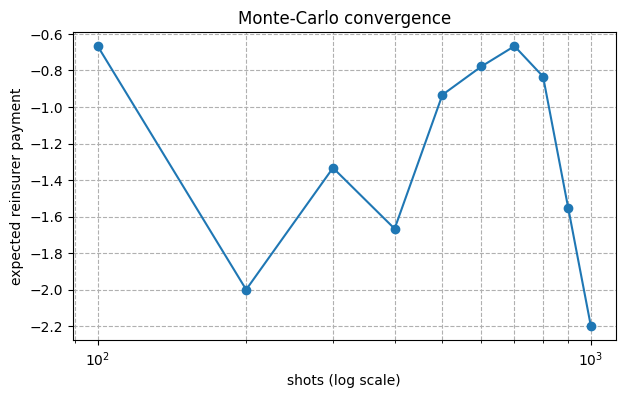

,shots,expected_payment
0,100.0,-0.666667
1,200.0,-2.000000
2,300.0,-1.333333
3,400.0,-1.666667
4,500.0,-0.933333
5,600.0,-0.777778
6,700.0,-0.666667
7,800.0,-0.833333
8,900.0,-1.555556
9,1000.0,-2.200000


In [ ]:
df_conv = convergence_study(qc,
                            meas_idx=meas_idx,
                            c_param=c_param,
                            coins=coins,
                            shot_grid=np.linspace(100, 1_000, 10))
# Save for later comparison, if you like
df_conv.to_csv("mc_convergence.csv", index=False)
df_conv

## Classical Monte Carlo

In [ ]:
import scipy.stats as stats

np.random.seed(42)  # For reproducibility

cmc_samples = 100_000

cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = stats.lognorm.rvs(sigma, loc=0, scale=np.exp(mu))

    # Calculate payout
    payout = 0 if lnorm <= 1 else lnorm - (1 - coins) * (lnorm - deductible) - deductible
    
    # Store the results
    cmc_results[i] = payout

    # Calculate clipped payout on [0, 10]
    lnorm_0_10 = lnorm if lnorm <= 10 else 10
    payout_0_10 = 0 if lnorm_0_10 <= 1 else lnorm_0_10 - (1 - coins) * (lnorm_0_10 - deductible) - deductible
    cmc_results_0_10[i] = payout_0_10


C:\Users\alexf\AppData\Local\Temp\ipykernel_67604\2597867.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, None, 0, None])


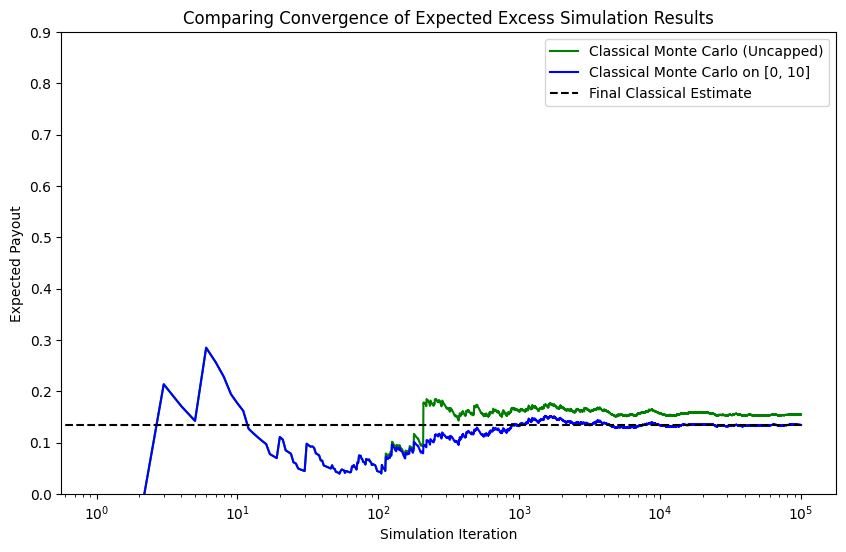

In [ ]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo (Uncapped)')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on [0, 10]')
# plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=cmc_running_mean_0_10[-1], xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Final Classical Estimate')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 0.9)
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

In [ ]:
cmc_running_mean_0_10[-1]

np.float64(0.13465517755970566)

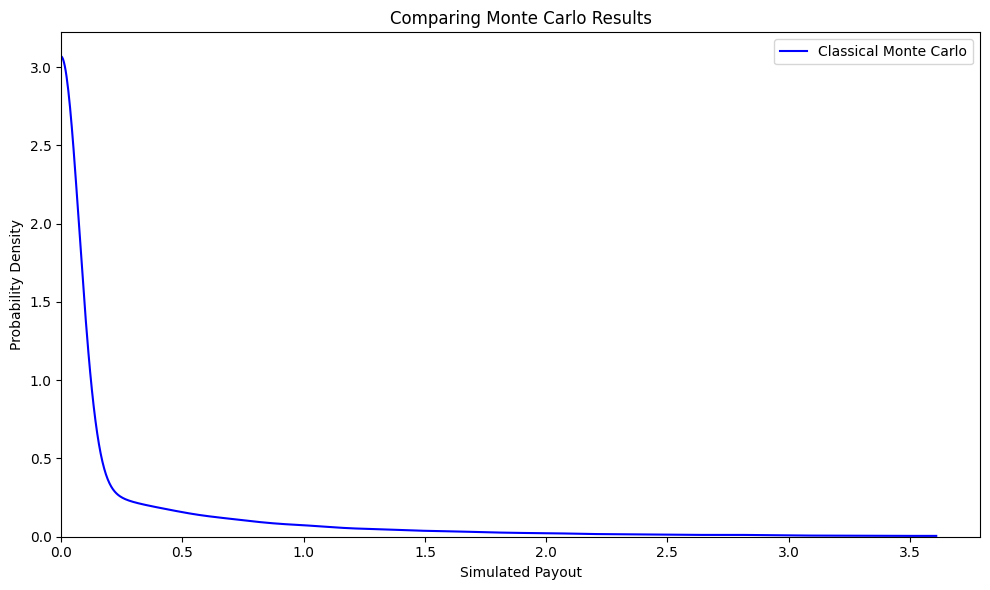

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = stats.gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()